In [1]:
from lifelines import CoxPHFitter, datasets, KaplanMeierFitter
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.cluster import hierarchy #import dendrogram
import seaborn
from PIL import Image
import matplotlib.colors as colors
import umap
import matplotlib.patches as mpatches
from scipy.stats import chi2_contingency
# import patsy
import matplotlib.patheffects as path_effects
from matplotlib.colors import ListedColormap

In [2]:
cluster_colors = ['#ff716c', '#a1a839', '#3fbe7c', '#42b8e7', '#bd78bb', '#b1cde9']
cluster_names = ['TIL-high/Fibro-low', 'TIL-med/Fibro-hi/EMT', 'TIL-hi/Fibro-hi/Inflamm', 'TumorDense', 'TumorDense/Oxidative', 'Fibro-med/TIL-low']
merged_cluster_names = ['m1', 'm2', 'm3', 'm4']
measure_names = ['KL(T <- L)', 'KL(T <- F)', 'KL(F <- L)', 'Tumor cells ratio', 'Lymphocyte ratio', 'Fibroblast ratio']
measure_cols = ['kl_tl', 'kl_tf', 'kl_fl', 'count_t', 'count_l', 'count_f']
normalized_measure_cols = [n + '_n' for n in measure_cols]

In [3]:
b = pd.read_csv('../data/icgc.csv')
m = pd.read_csv('../data/metabric.csv')

In [4]:
b_hl = hierarchy.linkage(b[normalized_measure_cols].values, 
                      method='complete', #'signle', 'ward', 'average', 'complete'
                      metric='cosine', #'euclidean', 'cosine', 'correlation'
                     )
translate_basis = {x:x for x in range(1, 6)}
merge_basis_on_translated_clusters = {1:1, 2:2, 3:1, 4:3, 5:4}
dn = hierarchy.dendrogram(b_hl, leaf_font_size=9, color_threshold=1.75, no_plot=True)
indx = dn['leaves']
dncuts = [164, 220, 12, 65]
cuts = [0] + [indx.index(i) for i in dncuts] + [len(indx)]
b_colors = [j for i in range(len(cuts) - 1) for j in [i]*(cuts[i+1] - cuts[i])]
b_clusters = [b_colors[indx.index(i)] + 1  for i in range(b.shape[0])]
b['clusters'] = [translate_basis[x] for x in b_clusters]
b['clusters_merged'] = [merge_basis_on_translated_clusters[translate_basis[x]] for x in b_clusters]

In [5]:
m_hl = hierarchy.linkage(m[normalized_measure_cols].values, 
                      method='complete', #'signle', 'ward', 'average'
                      metric='cosine', #'euclidean', 'cosine'
                     )
translate_metabric = {1:3, 2:1, 3:2, 4:4, 5:6, 6:5}
dn = hierarchy.dendrogram(m_hl, leaf_font_size=9, color_threshold=1.51, no_plot=True)
indx = dn['leaves']
dncuts = [344, 261, 135, 282, 327]
cuts = [0] + [indx.index(i) for i in dncuts] + [len(indx)]
m_colors = [j for i in range(len(cuts) - 1) for j in [i]*(cuts[i+1] - cuts[i])]
m_clusters = [m_colors[indx.index(i)] + 1 for i in range(m.shape[0])]
# translate_metabric = {0: 2, 1: 0, 2: 1, 3: 4, 4: 5, 5: 3}
m['clusters'] = [translate_metabric[x] for x in m_clusters]
merge_metabric_on_translated_clusters = {1:1, 2:2, 3:1, 4:3, 5:4, 6:4}
m['clusters_merged'] = [merge_metabric_on_translated_clusters[translate_metabric[x]] for x in m_clusters]

In [6]:
with open('../data/final_clustering.pkl', 'wb') as f:
    pickle.dump({'basis': b, 'metabric': m, 'measure_cols': measure_cols, 
                 'normalized_measure_cols': normalized_measure_cols,
                 'measure_names': measure_names, 'cluster_colors': cluster_colors, 
                 'cluster_names': cluster_names, 'merged_cluster_names': merged_cluster_names}, f)

In [7]:
palettes = [ListedColormap(cluster_colors)(colors.Normalize()([0, 1, 2, 3 , 4, 5])),
            plt.cm.PuRd(colors.Normalize(vmin=0, vmax=1.2)([0, 1])),
            np.concatenate(([[.7, .7, .7, 1.]], plt.cm.PuRd(colors.Normalize(vmin=0, vmax=1.2)([0, 1])))),
            np.concatenate(([[.7, .7, .7, 1.]], plt.cm.viridis(colors.Normalize(vmin=0.1, vmax=3.1)([1, 2, 3])))),
            plt.cm.PuRd(colors.Normalize(vmin=0, vmax=1.2)([0, 1]))]

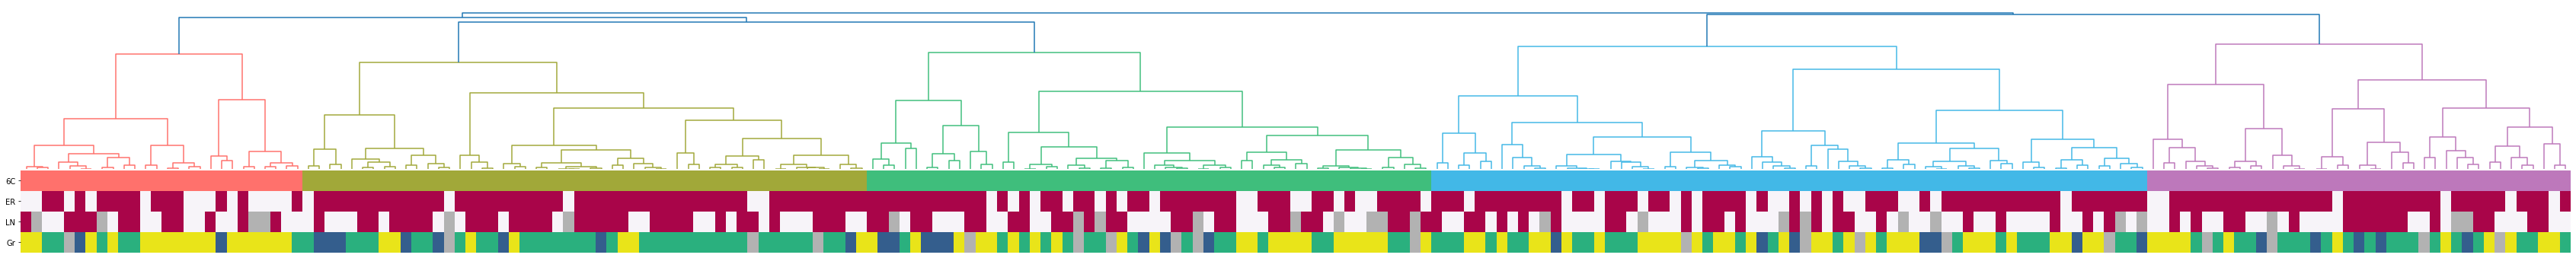

In [8]:
hierarchy.set_link_color_palette(cluster_colors)
fig = plt.figure(figsize=(60, 8))
fig.patch.set_facecolor('white')

rows = [b['clusters'].values - 1, 
        b['final.ER_x'].apply(lambda x: 1 if x == 'positive' else 0).values,
        b['number_of_positive_lymph_nodes'].apply(lambda x: 1 + (int(x) >= 1) if not pd.isna(x) else 0).values,
        b['grade'].apply(lambda x: int(x) if not pd.isna(x) else 0).values
       ]

row_colors = np.stack([palettes[i][rows[i]] for i in range(len(rows))], axis=1).transpose((1, 0, 2))
gs = gridspec.GridSpec(3, 1, height_ratios=[2, 1, 1])
gs.update(wspace=0.0, hspace=0.01) # set the spacing between axes. 
#
ax = plt.subplot(gs[0])
plt.axis('off')
dn = hierarchy.dendrogram(b_hl, leaf_font_size=9, color_threshold=1.75)
#
ax = plt.subplot(gs[1])
plt.imshow(row_colors[:,dn['leaves']] , aspect='auto')
ax.axes.get_yaxis().set_visible(True)
ax.axes.get_xaxis().set_visible(False)
ax.set_yticklabels(['', '6C', 'ER', 'LN', 'Gr'])
ax.set_xticklabels([])
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.savefig('../figures/fig_ICGC_hierarchical.png', facecolor='w', format='png')

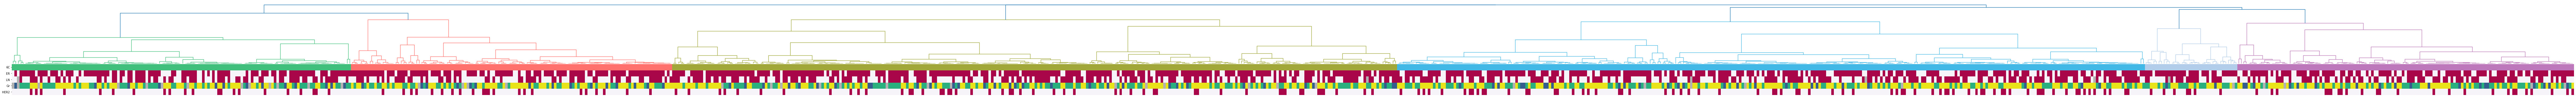

In [9]:
hierarchy.set_link_color_palette([cluster_colors[i - 1] for i in translate_metabric.values()])
fig = plt.figure(figsize=(160, 8))
fig.patch.set_facecolor('white')

rows = [m['clusters'].values - 1, 
        m['er_status'].apply(lambda x: 1 if x == 'pos' else 0).values,
        m['node'].apply(lambda x: int(x) + 1 if not pd.isna(x) else 0).values,
        m['grade'].apply(lambda x: int(x) if not pd.isna(x) else 0).values,
        m['HER2'].apply(lambda x: 1 if x == 'pos' else 0).values
       ]
row_colors = np.stack([palettes[i][rows[i]] for i in range(len(rows))], axis=1).transpose((1, 0, 2))
#
gs = gridspec.GridSpec(3, 1, height_ratios=[2, 1, 1])
gs.update(wspace=0.0, hspace=0.01) # set the spacing between axes. 
#
ax = plt.subplot(gs[0])
plt.axis('off')
dn = hierarchy.dendrogram(m_hl, leaf_font_size=9, color_threshold=1.51)
#
ax = plt.subplot(gs[1])
plt.imshow(row_colors[:,dn['leaves']] , aspect='auto')
ax.axes.get_yaxis().set_visible(True)
ax.axes.get_xaxis().set_visible(False)
ax.set_yticklabels(['', '6C', 'ER', 'LN', 'Gr', 'HER2'])
ax.set_xticklabels([])
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.savefig('../figures/fig_METABRIC_hierarchical.png', facecolor='w', format='png')

In [10]:
##:~